In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnnweightsh5/allmias1xD 256 (opt val_loss 0.45).h5
/kaggle/input/cnnweightsh5/model_2_4cl_end.h5
/kaggle/input/cnnweightsh5/trainHistoryDict
/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067

INFORMATION:

This file lists the films in the MIAS database and provides     
appropriate details as follows:

1st column: MIAS database reference number.

2nd column: Character of background tissue: 
                F - Fatty 
                G - Fatty-glandular
                D - Dense-glandular

3rd column: Class of abnormality present:
                CALC - Calcification
                CIRC - Well-defined/circumscribed masses
                SPIC - Spiculated masses
                MISC - Other, ill-defined masses
                ARCH - Architectural distortion
                ASYM - Asymmetry
                NORM - Normal

4th column: Severity of abnormality;
                B - Benign
                M - Malignant
                
5th,6th columns: x,y image-coordinates of centre of abnormality.

7th column: Approximate radius (in pixels) of a circle enclosing
            the abnormality.
            
NOTES

1- The list is arranged in pairs of films, where each pair 
   represents the left (even filename numbers) and right mammograms
   (odd filename numbers) of a single patient.
   
2- The size of ALL the images is 1024 pixels x 1024 pixels. The images
   have been centered in the matrix.  

3- When calcifications are present, centre locations and radii 
   apply to clusters rather than individual calcifications.
   Coordinate system origin is the bottom-left corner.

4- In some cases calcifications are widely distributed throughout
   the image rather than concentrated at a single site. In these
   cases centre locations and radii are inappropriate and have
   been omitted.

In [2]:
# system related
import os
import sys
import pickle
import itertools

import tensorflow as tf

# keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import models
from keras import regularizers

# path manipulation
from pathlib import Path

# regex
import re

# image manipulation
from IPython.display import Image

# data manipulation / preparation
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# data and Image manipulation / preparation
import cv2
import pandas as pd
import numpy as np
from PIL import Image


# plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [3]:
 !nvidia-smi

Sat Apr 22 15:52:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
#Check if GPUs are detected
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


 ### Citation for the class MammoScan and the collection of functions right after.
*    Title: mias_mammography
*    Author: Poles, Carlos
*    Date: 06/2021
*    Availability: https://github.com/cpoles/data_science/tree/main/projects/deep_learning/mias_mammography/src/modules
* Refere to the sign '*' for citation.

In [4]:
'''
Author: Poles, Carlos *
'''

class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info
    
    @property # scan image
    def scan(self):
        return self.__scan
    
    @property # scan info
    def scan_info(self):
        return self.__sc_info
    
    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name
    
    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x
    
    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y
    
    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class
    
    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg
    
    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property 
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()
    
    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)
    
    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)
        

        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)
    
    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue
    
    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue
    
    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue
        
    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)
            
        return (self.x, 1024.0-self.y, self.radius)
    
    # private method
    def __transform(self):
        '''Creates a dict 
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((256,256))
        # create rotated images
        for angle in (0, 90, 180, 270):
#         for angle in (0, 45, 90, 135, 180, 225, 270, 315):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)
            
            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'], 
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [5]:
'''
Author: Poles, Carlos *
'''
def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index
    
    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)
    
    return new_df


def delete_image(filename: str, directory='../all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}') 
            
            
def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()
    
    return img_dic
        

def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
    '''Save subsamples to the subsamples folder'''
    # define subsamples folder
    folder = '../subsamples'
    df_sub = pd.DataFrame()
    try:
        # create if not yet
        if not os.path.exists(folder):
            os.mkdir(folder)
    except:
        print('An error occurred when searching for the folder')
        
    # iterate dictionary of filenames
    for scan_name, filename in scans_dic.items():
        
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = df.loc[scan_name].copy()
        # create the MammoScan object
        m_scan = MammoScan(scan, scan_info)
        # get the transformations
        transf_scans = m_scan.transformations
        # create filenames
        filenames = create_subsample_filename(scan_name, transf_scans)
        # get transformed scans Image objects
        imgs = get_transformed_scans(transf_scans)
        # prepare for saving
        fs_and_is = list(zip(filenames, imgs))
        
        for filename, image in fs_and_is:
            # create new observation with subsample name
            # name the series to become an index in the new dataframe
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            # create pixel matrix
            pixel_matrix = np.asarray(image)
            
            scan_info['p_matrix'] = pixel_matrix
            
            scan_info['subsample_path'] = os.path.join('../subsamples', filename)

            # append to dataframe
            df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg', 
                                                  'severity', 'subsample_path',
                                                  'p_matrix']])
            
            #print(scan_name)././
            path = os.path.join('../subsamples', filename) 
            #print(path)
            try:
                image.save(path, compress_level=0)
            except ValueError as ve:
                print('Output format could not be determined from the file name.')
            except OSError as ose:
                print('File could not be written.')
                print({ose})
        
    return df_sub


def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''
            
    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)
    
    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)   
    
    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']
    
    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)
        
    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('N')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)
    
    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')
    
    
    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()
    
    
def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(864, replace = True) # Changed from 96 and replace False
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(144, replace = True)
            class_df_A = class_df[class_df.severity == 'M'].sample(144, replace = True)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)
""
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')
        
def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])


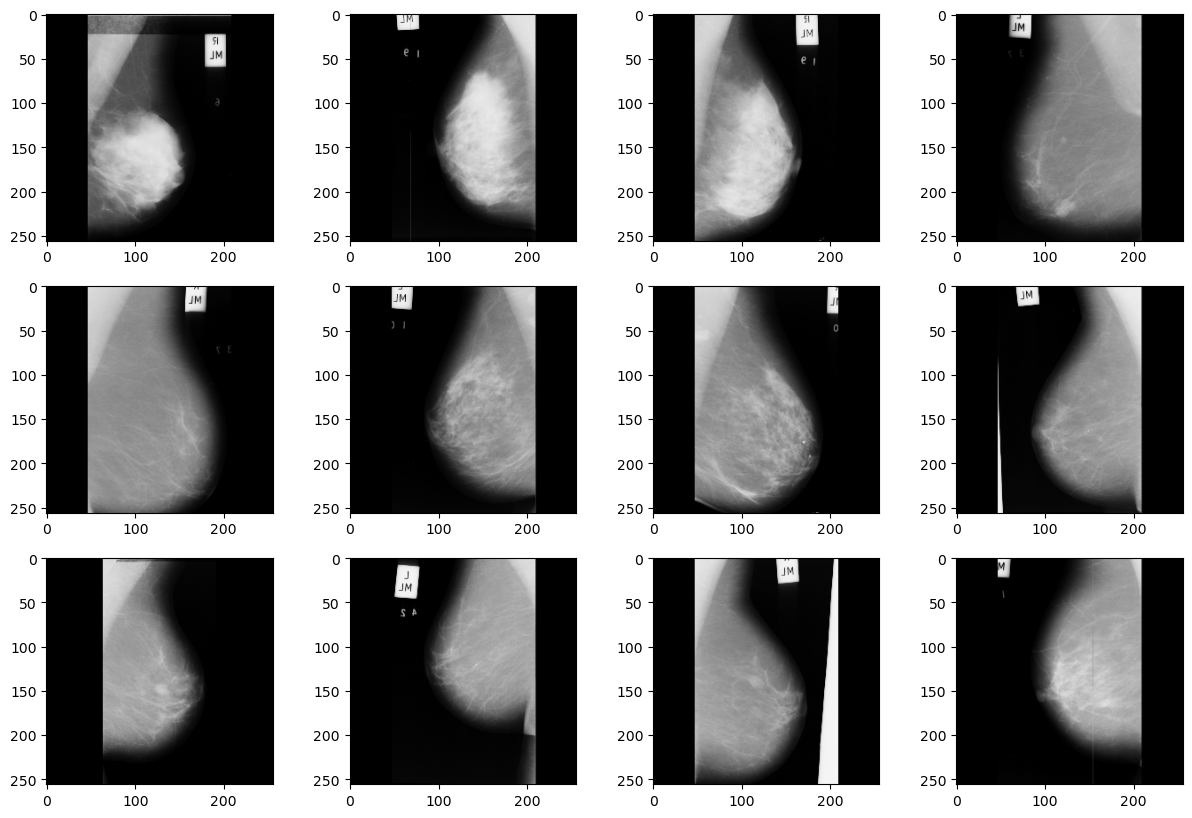

In [7]:
import glob
import seaborn as sns

samples_list = []
for filename in sorted(glob.glob("../input/mias-mammography/all-mias/*.pgm")): 
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256))
    samples_list.append(img)
fig = plt.figure(figsize = (15, 10))
columns = 4
rows = 3
for i in range(1, columns * rows + 1):
    img = np.random.randint(i)
    fig.add_subplot(rows, columns, i)
    plt.imshow(samples_list[i])
# plt.show()

#### Data Distribution

The NORM class, which accounts for the scans with no abnormalities, stands for 64.8% of the scan samples. Its severity was defined as 'A' and it happens during the creation of the mias dataframe.

There is also a slight difference between Malign (M) and Benign (B) samples in all classes

The strategy to atenuate such disparity is to randomly remove whichever class is predominant (either M or N) so that we can have a balanced set. Classes to be balanced prior to be tested to ensure randomness.

As for the NORM class, it will reduced, also randomly, to the average of the samples for each class

In [6]:
mammo = create_mias_dataset("../input/mias-mammography/Info.txt")
mammo

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,N,NaN,NaN,NaN
mdb004,D,NORM,N,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,N,NaN,NaN,NaN
mdb319,D,NORM,N,NaN,NaN,NaN
mdb320,D,NORM,N,NaN,NaN,NaN


In [7]:
mias = generate_subsamples("../input/mias-mammography/all-mias/", mammo)
mias

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.


,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ..."
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,..."
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,..."
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ..."
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,N,../subsamples/mdb322_180_mirr_lr.png,"[[199, 199, 198, 197, 197, 196, 195, 195, 195,..."
mdb322_180_mirr_tp,NORM,D,N,../subsamples/mdb322_180_mirr_tp.png,"[[204, 204, 204, 205, 205, 206, 206, 206, 205,..."
mdb322_270_rotated,NORM,D,N,../subsamples/mdb322_270_rotated.png,"[[199, 199, 199, 198, 198, 198, 197, 196, 196,..."
mdb322_270_mirr_lr,NORM,D,N,../subsamples/mdb322_270_mirr_lr.png,"[[177, 177, 177, 177, 177, 176, 176, 176, 177,..."


In [8]:
all_mias_full = full_balance_df_by_severity(mias)
all_mias_full

,ab_class,bg,severity,subsample_path,p_matrix
mdb258_0_mirr_tp,NORM,D,N,../subsamples/mdb258_0_mirr_tp.png,"[[176, 176, 175, 175, 175, 174, 174, 174, 173,..."
mdb097_0_rotated,ASYM,F,B,../subsamples/mdb097_0_rotated.png,"[[166, 166, 166, 165, 164, 164, 164, 165, 165,..."
mdb218_270_mirr_tp,CALC,G,B,../subsamples/mdb218_270_mirr_tp.png,"[[179, 179, 179, 179, 179, 179, 179, 179, 179,..."
mdb109_0_rotated,NORM,D,N,../subsamples/mdb109_0_rotated.png,"[[199, 199, 199, 198, 198, 196, 195, 194, 193,..."
mdb030_90_mirr_lr,MISC,G,B,../subsamples/mdb030_90_mirr_lr.png,"[[201, 201, 200, 199, 199, 200, 201, 202, 202,..."
...,...,...,...,...,...
mdb097_90_rotated,ASYM,F,B,../subsamples/mdb097_90_rotated.png,"[[171, 171, 171, 171, 171, 171, 171, 170, 170,..."
mdb170_0_rotated,ARCH,D,M,../subsamples/mdb170_0_rotated.png,"[[125, 125, 125, 124, 122, 120, 120, 121, 123,..."
mdb300_180_rotated,NORM,F,N,../subsamples/mdb300_180_rotated.png,"[[134, 134, 134, 134, 134, 134, 133, 133, 133,..."
mdb186_180_rotated,SPIC,G,M,../subsamples/mdb186_180_rotated.png,"[[177, 177, 177, 177, 177, 178, 178, 178, 177,..."


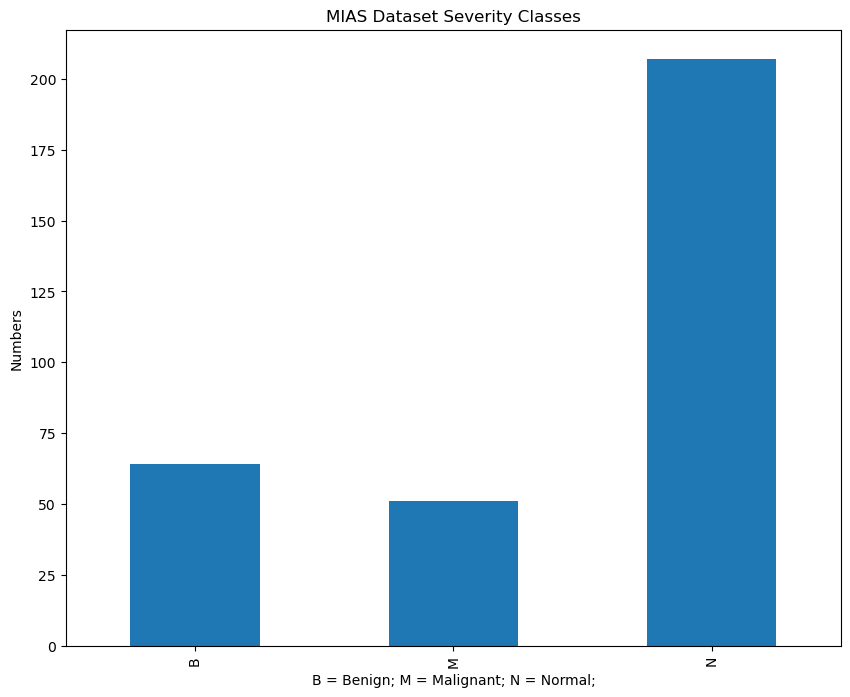

In [9]:
mammo.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant; N = Normal;', 
                                                 ylabel='Numbers',
                                                 title='MIAS Dataset Severity Classes');
plt.savefig("MIAS Dataset Distribution")

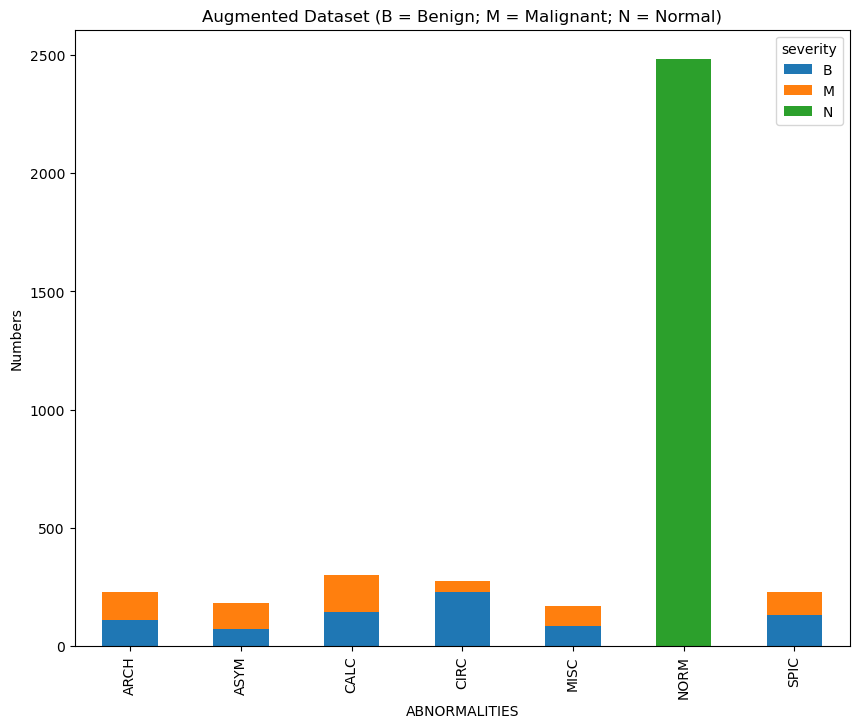

In [10]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numbers',
                                                              title='Augmented Dataset (B = Benign; M = Malignant; N = Normal)');
plt.savefig('MIAS Augmented Unbalanced Distribution.png')

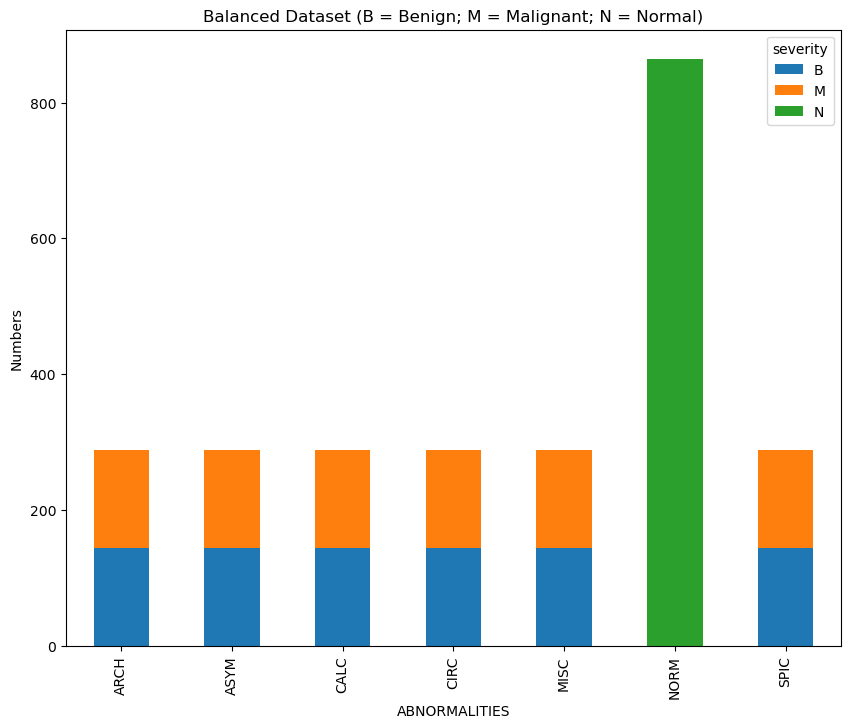

In [16]:
all_mias_full.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numbers',
                                                              title='Balanced Dataset (B = Benign; M = Malignant; N = Normal)');

plt.savefig('MIAS Augmented Balanced Distribution.png')

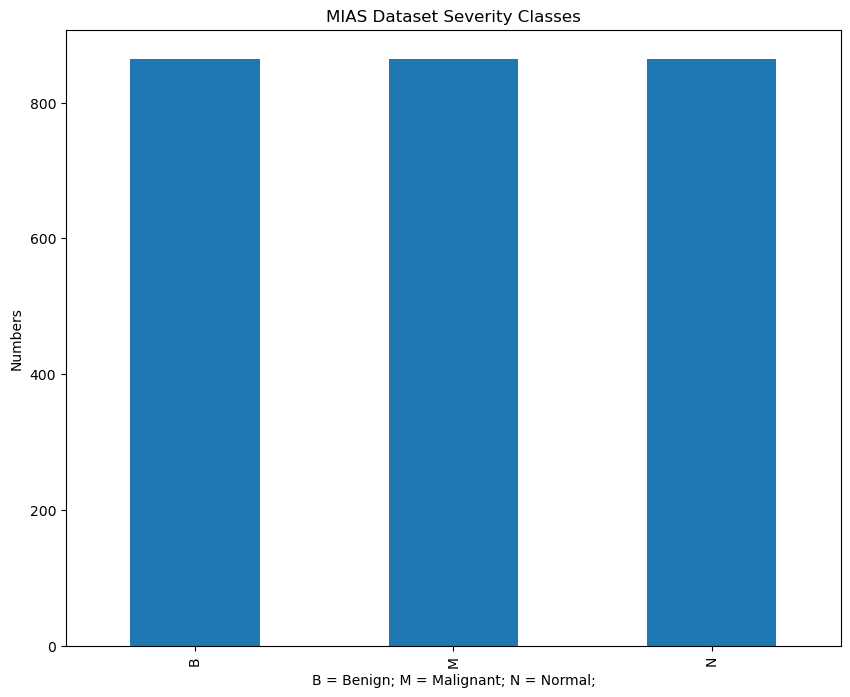

In [12]:
all_mias_full.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant; N = Normal;', 
                                                 ylabel='Numbers',
                                                 title='MIAS Dataset Severity Classes');

plt.savefig('MIAS Augmented Balanced Distribution (Severity only).png')

## Trial 0


### After applying different kinds of augmentation techniques at the creation phase of the dataframe, a balanced has been achieved by applying 45 degree rotation, plus mirroring up to down, left to right each image at each rotation, this has yielded a promising 2400% extra data 7728 total sample precisely. By then balancing the dataset for the task of multi-class of breast tumour (B, M or N (Healthy)) to circa 2592 samples in total.
#### This will now be ulteriorly augmented on the fly, normalized and resized and coupled with the right label, to be put into training, validation and test sets for the fitting of the data. The following will be done using 3 different sizes to compare the performance of the model.

In [13]:
def dataset_gen(dataset, image_size, batch_size):
    # Load data into a dataframe
    data_df = dataset
    # Split data into training, validation, and testing sets
    train_df, val_test_df = train_test_split(data_df, test_size=0.25, stratify=data_df['severity'])
    val_df, test_df = train_test_split(val_test_df, test_size=0.2, stratify=val_test_df['severity'])

    '''
    training set = 75%, validation set = 20%, and testing set = 5%
    '''
    # Define data generators
    train_datagen = ImageDataGenerator(horizontal_flip=True,
                                      height_shift_range=.10, 
                                      width_shift_range=.10, 
                                      rotation_range=15,
                                      shear_range=10,
                                      rescale=1/255.)

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)


    # train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

    # Define image size and batch size
    img_size = image_size
    batch_size = batch_size

    # Training data generator
    train_data = train_datagen.flow_from_dataframe(
        train_df,
        x_col = 'subsample_path',
        y_col = 'severity',
        target_size = img_size,
        batch_size = batch_size,
        class_mode ='categorical',
        color_mode ="grayscale",
        shuffle = True
    )

    # Validation data generator
    val_data = val_datagen.flow_from_dataframe(
        val_df,
        x_col='subsample_path',
        y_col='severity',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="grayscale",
        shuffle=False
    )

    # Testing data generator
    test_data = test_datagen.flow_from_dataframe(
        test_df,
        x_col='subsample_path',
        y_col='severity',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="grayscale",
        shuffle=False
    )

    # Get the true class labels for the testing data
    test_labels = test_data.labels
    
    return train_data, val_data, test_data, test_labels

## Trial 0
### this will be splitted in 2 using two approaches, one with dropout and the other without regularization to compare the results.

In [14]:
train_data_0, val_data_0, test_data_0, test_labels_0 = dataset_gen(all_mias_full, (48, 48), 32)

Found 1944 validated image filenames belonging to 3 classes.
Found 518 validated image filenames belonging to 3 classes.
Found 130 validated image filenames belonging to 3 classes.


In [16]:
train_class_indices = train_data_0.class_indices
val_class_indices = val_data_0.class_indices
test_class_indices = test_data_0.class_indices

### Checking Label mapping for the class names.

In [52]:
class_names = {value: key for key, value in train_class_indices.items()}
pred_class_names = [class_names[label] for label in test_labels_0]
pred_class_names

['M',
 'B',
 'M',
 'B',
 'M',
 'N',
 'N',
 'B',
 'N',
 'N',
 'N',
 'B',
 'B',
 'B',
 'N',
 'B',
 'M',
 'M',
 'M',
 'N',
 'B',
 'N',
 'N',
 'M',
 'M',
 'B',
 'M',
 'N',
 'M',
 'B',
 'B',
 'B',
 'M',
 'M',
 'N',
 'B',
 'B',
 'B',
 'N',
 'M',
 'M',
 'N',
 'B',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'B',
 'B',
 'M',
 'M',
 'N',
 'N',
 'M',
 'B',
 'M',
 'N',
 'N',
 'M',
 'M',
 'B',
 'B',
 'M',
 'M',
 'B',
 'M',
 'N',
 'B',
 'N',
 'B',
 'M',
 'M',
 'M',
 'N',
 'B',
 'B',
 'M',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'B',
 'M',
 'B',
 'M',
 'N',
 'N',
 'B',
 'B',
 'N',
 'B',
 'N',
 'B',
 'M',
 'N',
 'N',
 'M',
 'N',
 'B',
 'M',
 'M',
 'N',
 'B',
 'N',
 'B',
 'M',
 'B',
 'M',
 'B',
 'B',
 'N',
 'N',
 'B',
 'N',
 'B',
 'M',
 'B',
 'M',
 'M',
 'B',
 'N',
 'N',
 'N',
 'B',
 'N']

In [62]:
line_count = 0
b, m, n = 0, 0, 0
for line in pred_class_names:
        # Increment the line count for each line
    if line == 'B':
        b += 1
    elif line == 'M':
        m += 1
    else:
        n += 1

# Print the total number of lines
print(f"Total number of benign: {b}")
print(f"Total number of malignant: {m}")
print(f"Total number of normal: {n}")

Total number of benign: 43
Total number of malignant: 44
Total number of normal: 43


In [51]:
class_names

{0: 'B', 1: 'M', 2: 'N'}

In [22]:
all_mias_0 = Sequential()

# first layer
all_mias_0.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
all_mias_0.add(Conv2D(64, kernel_size = (3, 3),activation='relu'))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
all_mias_0.add(Conv2D(128, kernel_size = (3, 3),activation='relu'))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_0.add(Dropout(0.25)) 
all_mias_0.add(Flatten())
all_mias_0.add(Dense(128, activation='relu'))
#                   activity_regularizer = regularizers.l2(1e-5))) 
# all_mias_0.add(Dropout(0.25))
all_mias_0.add(Dense(3, activation='softmax'))
# print summary
all_mias_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
'''
With Dropout Regularization
'''

all_mias_0 = Sequential()

# first layer
all_mias_0.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
all_mias_0.add(Conv2D(64, kernel_size = (3, 3),activation='relu'))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
all_mias_0.add(Conv2D(128, kernel_size = (3, 3),activation='relu'))
all_mias_0.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_0.add(Dropout(0.25)) 
all_mias_0.add(Flatten())
all_mias_0.add(Dense(128, activation='relu'))
#                   activity_regularizer = regularizers.l2(1e-5))) 
all_mias_0.add(Dropout(0.25))
all_mias_0.add(Dense(3, activation='softmax'))
# print summary
all_mias_0.summary()

In [16]:
'''
With Dropout Regularization
'''

# set optmizer and learning rate
adam = Adam(0.0001)
 
all_mias_0.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
# set callbacks
early_stopping = EarlyStopping(patience=70, restore_best_weights=True, monitor = 'val_loss', verbose = 1)

model_check_point = ModelCheckpoint(filepath= 'best_MIAS_multi_0_[48x48].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')
# Train the model
hist_0 = all_mias_0.fit(train_data_0, validation_data=val_data_0, 
                    epochs=2000, callbacks=[early_stopping, model_check_point])

Epoch 1/2000


2023-04-22 12:44:07.161540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/61 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.3447
Epoch 1: val_loss improved from inf to 1.09546, saving model to best_MIAS_multi_0_[48x48].h5
61/61 [==============================] - 12s 66ms/step - loss: 1.0970 - accuracy: 0.3447 - val_loss: 1.0955 - val_accuracy: 0.3263
Epoch 2/2000
61/61 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.3452
Epoch 2: val_loss improved from 1.09546 to 1.09382, saving model to best_MIAS_multi_0_[48x48].h5
61/61 [==============================] - 4s 59ms/step - loss: 1.0975 - accuracy: 0.3452 - val_loss: 1.0938 - val_accuracy: 0.3378
Epoch 3/2000
60/61 [============================>.] - ETA: 0s - loss: 1.0928 - accuracy: 0.3421
Epoch 3: val_loss improved from 1.09382 to 1.08758, saving model to best_MIAS_multi_0_[48x48].h5
61/61 [==============================] - 4s 59ms/step - loss: 1.0928 - accuracy: 0.3426 - val_loss: 1.0876 - val_accuracy: 0.3475
Epoch 4/2000
61/61 [===========================

In [24]:
# set optmizer and learning rate
adam = Adam(0.0001)
 
all_mias_0.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
# set callbacks
early_stopping = EarlyStopping(patience=70, restore_best_weights=True, monitor = 'val_loss', verbose = 1)

model_check_point = ModelCheckpoint(filepath= 'best_MIAS_multi_0[48x48].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')
# Train the model
hist_0 = all_mias_0.fit(train_data_0, validation_data=val_data_0, 
                    epochs=2000, callbacks=[early_stopping, model_check_point])

Epoch 1/2000
60/61 [============================>.] - ETA: 0s - loss: 1.0967 - accuracy: 0.3190
Epoch 1: val_loss improved from inf to 1.09390, saving model to best_MIAS_multi_0[48x48].h5
61/61 [==============================] - 4s 63ms/step - loss: 1.0970 - accuracy: 0.3194 - val_loss: 1.0939 - val_accuracy: 0.3475
Epoch 2/2000
61/61 [==============================] - ETA: 0s - loss: 1.0923 - accuracy: 0.3462
Epoch 2: val_loss improved from 1.09390 to 1.08465, saving model to best_MIAS_multi_0[48x48].h5
61/61 [==============================] - 4s 61ms/step - loss: 1.0923 - accuracy: 0.3462 - val_loss: 1.0846 - val_accuracy: 0.3514
Epoch 3/2000
60/61 [============================>.] - ETA: 0s - loss: 1.0762 - accuracy: 0.4032
Epoch 3: val_loss improved from 1.08465 to 1.05267, saving model to best_MIAS_multi_0[48x48].h5
61/61 [==============================] - 4s 60ms/step - loss: 1.0758 - accuracy: 0.4053 - val_loss: 1.0527 - val_accuracy: 0.5290
Epoch 4/2000
60/61 [==================

In [25]:
models.save_model(all_mias_0, 'MIAS_multi_0[48x48].h5')

In [19]:
# with open('/kaggle/working', 'wb') as file_pi:
#     pickle.dump(hist.history, file_pi)

In [ ]:
# with open('./trainHistoryDict', "rb") as file_pi:
#     hist = pickle.load(file_pi)

In [ ]:
# all_mias = models.load_model('./model_2_4cl_end.h5')
# all_mias.summary()

In [27]:
# predictions
predictions = all_mias_0.predict(test_data_0)
predicted = [np.argmax(w) for w in predictions]
expected = test_data_0.labels

# Evaluation Results
loss_value, accuracy = all_mias_0.evaluate(train_data_0)
print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

61/61 [==============================] - 3s 52ms/step - loss: 0.1246 - accuracy: 0.9609
Test loss_value: 0.12458227574825287
Test accuracy: 0.9609053730964661


### Without Regularization


In [26]:
# History of accuracy and loss
tra_loss_0 = hist_0.history['loss']
tra_acc_0 = hist_0.history['accuracy']
val_loss_0 = hist_0.history['val_loss']
val_acc_0 = hist_0.history['val_accuracy']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('best_MIAS_multi_0[48x48].h5')
test_loss_0, test_acc_0 = all_mias_0.evaluate(test_data_0,  verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_data_0,  verbose=False)
opt_pred_0 = opt_model_0.predict(test_data_0)
pred_classes_0 = np.argmax(opt_model_0.predict(test_data_0), axis=-1)

print("Model 0 [48x48]\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f" % opt_test_loss_0)

print(classification_report(test_labels_0, pred_classes_0, digits=4))

5/5 [==============================] - 0s 27ms/step
Model 0 [48x48]

Epoch [end]: 809
Epoch [opt]: 739
Valid accuracy [end]: 0.9653
Valid accuracy [opt]: 0.9653
Test accuracy [end]:  0.9538
Test accuracy [opt]:  0.9538
Valid loss [end]: 0.1396
Valid loss [opt]: 0.1173
Test loss [end]:  0.1830
Test loss [opt]:  0.1830
              precision    recall  f1-score   support

           0     0.9130    0.9767    0.9438        43
           1     0.9762    0.9318    0.9535        44
           2     0.9762    0.9535    0.9647        43

    accuracy                         0.9538       130
   macro avg     0.9551    0.9540    0.9540       130
weighted avg     0.9553    0.9538    0.9540       130



### With Dropout

In [18]:
'''
With Dropout Regularization
'''

# History of accuracy and loss
tra_loss_0 = hist_0.history['loss']
tra_acc_0 = hist_0.history['accuracy']
val_loss_0 = hist_0.history['val_loss']
val_acc_0 = hist_0.history['val_accuracy']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('best_MIAS_multi_0[48x48].h5')
test_loss_0, test_acc_0 = all_mias_0.evaluate(test_data_0,  verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_data_0,  verbose=False)
opt_pred_0 = opt_model_0.predict(test_data_0)
pred_classes_0 = np.argmax(opt_model_0.predict(test_data_0), axis=-1)

print("Model 0 [48x48]\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f" % opt_test_loss_0)

print(classification_report(test_labels_0, pred_classes_0, digits=4))

5/5 [==============================] - 0s 25ms/step
Model 0 [48x48]

Epoch [end]: 1082
Epoch [opt]: 1012
Valid accuracy [end]: 0.9942
Valid accuracy [opt]: 0.9923
Test accuracy [end]:  0.9846
Test accuracy [opt]:  0.8923
Valid loss [end]: 0.0851
Valid loss [opt]: 0.0681
Test loss [end]:  0.0800
Test loss [opt]:  0.3329
              precision    recall  f1-score   support

           0     0.9250    0.8605    0.8916        43
           1     0.8269    0.9773    0.8958        44
           2     0.9474    0.8372    0.8889        43

    accuracy                         0.8923       130
   macro avg     0.8998    0.8916    0.8921       130
weighted avg     0.8992    0.8923    0.8921       130



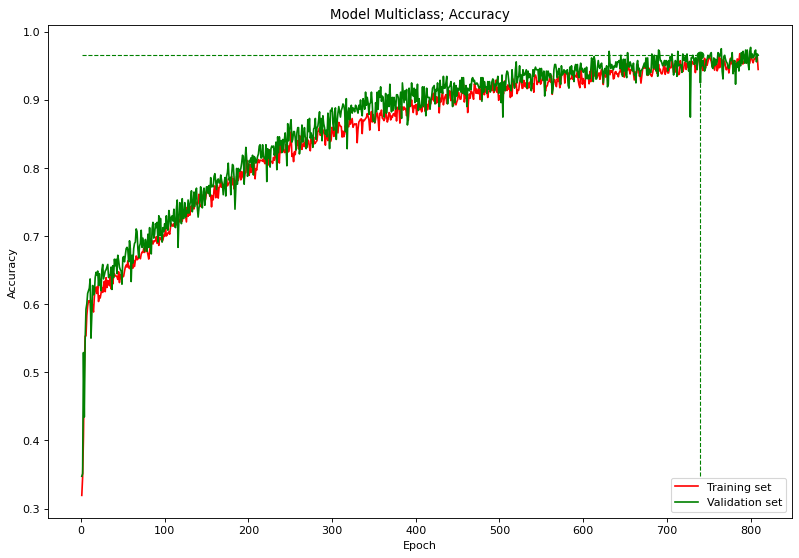

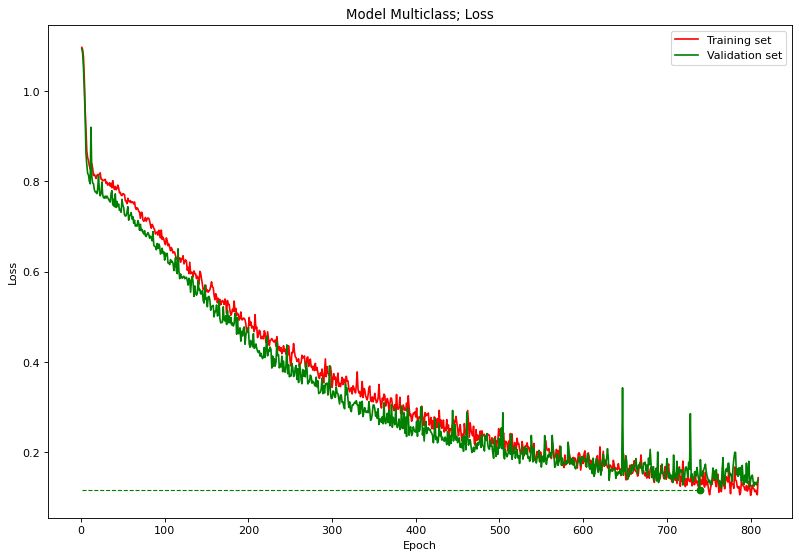

In [28]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
# plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();
# plt.savefig('Model0Loss_figure.png')

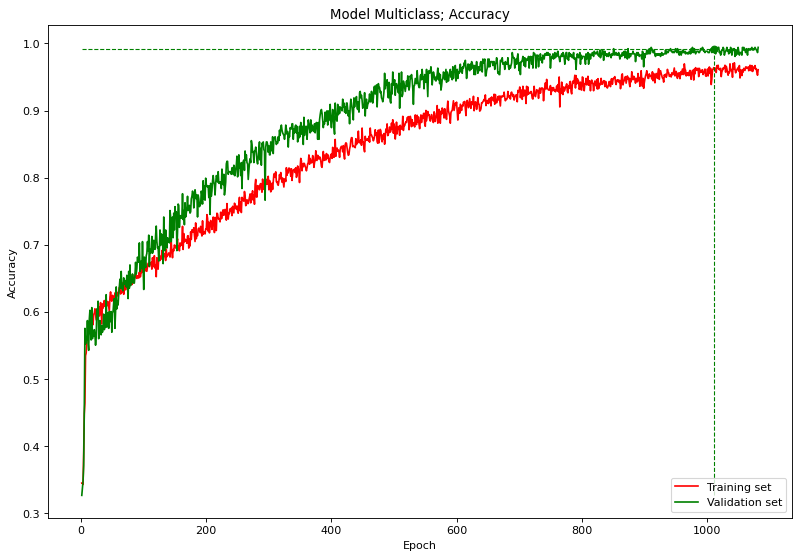

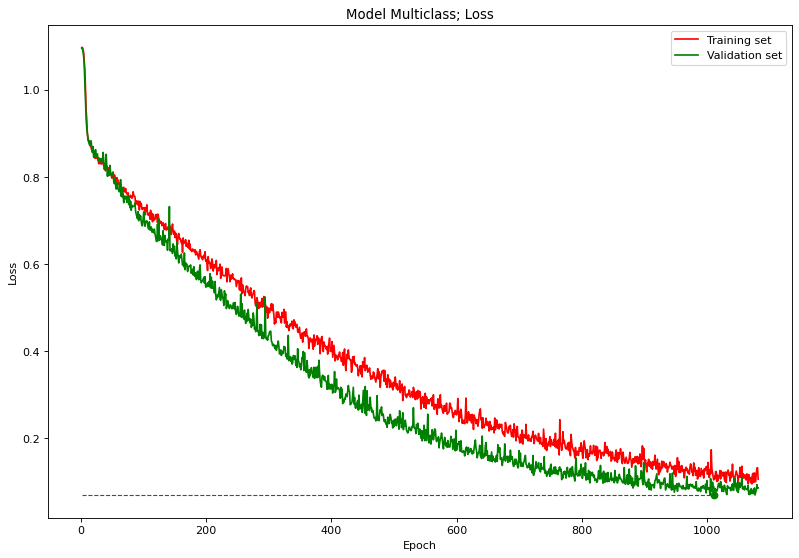

In [19]:
'''
With Dropout Regularization
'''

# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model0Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model0Loss_figure.png')

## Trial 1

### For the next experiment, this time the regulations techniques will have to be tunred down slightly, as the validation set had a better performance throughout the past training, and this is due to over regularization. This time, the image size will be increased, this ideally should bring similar results, the batch_size will stay the same.

In [29]:
train_data_1, val_data_1, test_data_1, test_labels_1 = dataset_gen(all_mias_full, (144, 144), 32)

Found 1944 validated image filenames belonging to 3 classes.
Found 518 validated image filenames belonging to 3 classes.
Found 130 validated image filenames belonging to 3 classes.


In [ ]:
# all_mias_1 = Sequential()
# # first layer
# all_mias_1.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(144, 144, 1)))
# all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_1.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
# all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_1.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
# all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_1.add(Flatten())
# all_mias_1.add(Dense(256, activation='relu')
# #                    activity_regularizer = regularizers.l2(5e-4)))
# all_mias_1.add(Dropout(0.25))
# # all_mias_1.add(Dense(128, activation='relu',
# #                   activity_regularizer = regularizers.l2(5e-4))) 
# # all_mias_1.add(Dropout(0.25))
# all_mias_1.add(Dense(3, activation='softmax'))
# # print summary
# all_mias_1.summary()

In [31]:
all_mias_1 = Sequential()
# first layer
all_mias_1.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(144, 144, 1)))
all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
all_mias_1.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
all_mias_1.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
all_mias_1.add(Conv2D(256, kernel_size = (3,3),activation='relu'))
all_mias_1.add(MaxPool2D(pool_size=2, strides=2))
all_mias_1.add(Flatten())
all_mias_1.add(Dense(128, activation='relu'))
#                    activity_regularizer = regularizers.l2(5e-4)))
all_mias_1.add(Dropout(0.25))
# all_mias_1.add(Dense(128, activation='relu',
#                   activity_regularizer = regularizers.l2(5e-4))) 
# all_mias_1.add(Dropout(0.25))
all_mias_1.add(Dense(3, activation='softmax'))
# print summary
all_mias_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 69, 69, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)     

In [32]:
# set optmizer and learning rate
adam = Adam(0.0001)
 
all_mias_1.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
# set callbacks
early_stopping = EarlyStopping(patience=70, restore_best_weights=True, monitor = 'val_loss', verbose = 1)

model_check_point = ModelCheckpoint(filepath= 'best_MIAS_multi_1[144x144].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# Train the model
hist_1 = all_mias_1.fit(train_data_1, validation_data=val_data_1, 
                    epochs=2000, callbacks=[early_stopping, model_check_point])

Epoch 1/2000
61/61 [==============================] - ETA: 0s - loss: 1.0994 - accuracy: 0.3338
Epoch 1: val_loss improved from inf to 1.09615, saving model to best_MIAS_multi_1[144x144].h5
61/61 [==============================] - 8s 118ms/step - loss: 1.0994 - accuracy: 0.3338 - val_loss: 1.0962 - val_accuracy: 0.3340
Epoch 2/2000
61/61 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.3266
Epoch 2: val_loss improved from 1.09615 to 1.08740, saving model to best_MIAS_multi_1[144x144].h5
61/61 [==============================] - 7s 118ms/step - loss: 1.0945 - accuracy: 0.3266 - val_loss: 1.0874 - val_accuracy: 0.3340
Epoch 3/2000
61/61 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.3668
Epoch 3: val_loss improved from 1.08740 to 1.06928, saving model to best_MIAS_multi_1[144x144].h5
61/61 [==============================] - 7s 107ms/step - loss: 1.0812 - accuracy: 0.3668 - val_loss: 1.0693 - val_accuracy: 0.3359
Epoch 4/2000
61/61 [=========

In [36]:
models.save_model(all_mias_1, 'MIAS_multi_1[256x256].h5')

In [37]:
# History of accuracy and loss
tra_loss_1 = hist_1.history['loss']
tra_acc_1 = hist_1.history['accuracy']
val_loss_1 = hist_1.history['val_loss']
val_acc_1 = hist_1.history['val_accuracy']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('best_MIAS_multi_1[144x144].h5')
test_loss_1, test_acc_1 = all_mias_1.evaluate(test_data_1, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_data_1, verbose=False)
opt_pred_1 = opt_model_1.predict(test_data_1)
pred_classes_1 = np.argmax(opt_model_1.predict(test_data_1), axis=-1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels_1, pred_classes_1, digits=4))

5/5 [==============================] - 0s 31ms/step
Model 1

Epoch [end]: 739
Epoch [opt]: 669
Valid accuracy [end]: 0.9807
Valid accuracy [opt]: 0.9923
Test accuracy [end]:  0.9846
Test accuracy [opt]:  0.9846
Valid loss [end]: 0.0717
Valid loss [opt]: 0.0219
Test loss [end]:  0.0678
Test loss [opt]:  0.0678
              precision    recall  f1-score   support

           0     0.9556    1.0000    0.9773        43
           1     1.0000    0.9535    0.9762        43
           2     1.0000    1.0000    1.0000        44

    accuracy                         0.9846       130
   macro avg     0.9852    0.9845    0.9845       130
weighted avg     0.9853    0.9846    0.9846       130



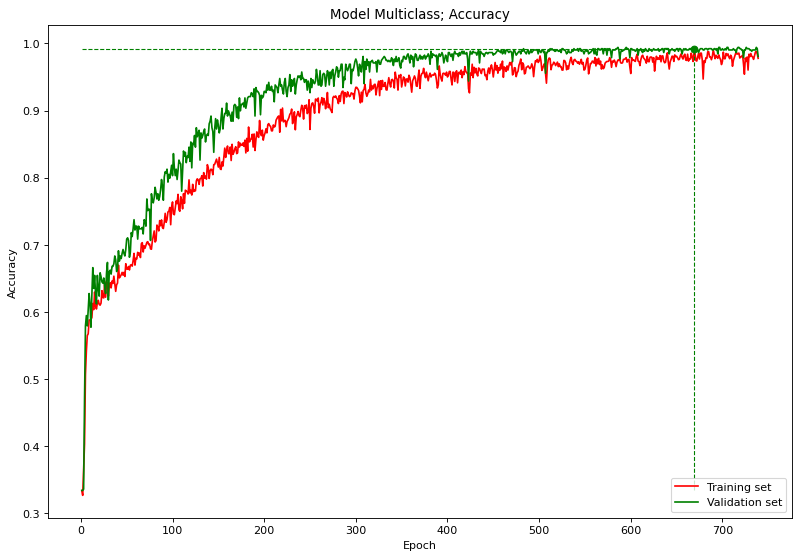

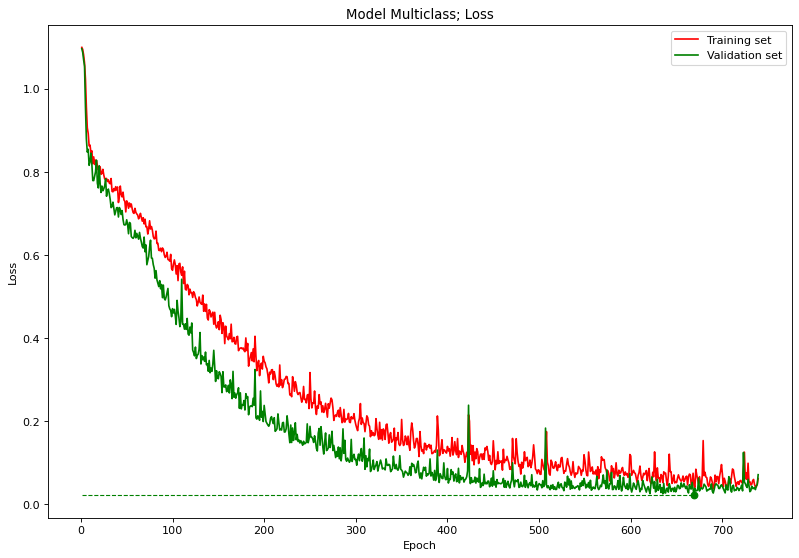

In [38]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model1Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model1Loss_figure.png')

## Trial 2

In [45]:
train_data_2, val_data_2, test_data_2, test_labels_2 = dataset_gen(all_mias_full, (256, 256), 32) # Original size of ROI images

Found 1944 validated image filenames belonging to 3 classes.
Found 518 validated image filenames belonging to 3 classes.
Found 130 validated image filenames belonging to 3 classes.


In [43]:
all_mias_2 = Sequential()
# first layer
all_mias_2.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(256, 256, 1)))
all_mias_2.add(MaxPool2D(pool_size=2, strides=2))
# all_mias_0.add(Dropout(0.25))
all_mias_2.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
all_mias_2.add(MaxPool2D(pool_size=2, strides=2))
all_mias_2.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
all_mias_2.add(MaxPool2D(pool_size=2, strides=2))
all_mias_2.add(Conv2D(256, kernel_size = (3,3),activation='relu'))
all_mias_2.add(MaxPool2D(pool_size=2, strides=2))
all_mias_2.add(Flatten())
all_mias_2.add(Dense(128, activation='relu'))
#                    activity_regularizer = regularizers.l2(1e-3)))
all_mias_2.add(Dropout(0.25)) # was 0.25
# all_mias_2.add(Dense(128, activation='relu',
#                   activity_regularizer = regularizers.l2(1e-3))) 
# all_mias_2.add(Dropout(0.25))
all_mias_2.add(Dense(3, activation='softmax'))
# print summary
all_mias_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 128)     

In [46]:
# set optmizer and learning rate
adam = Adam(0.0001)
 
all_mias_2.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True, monitor = 'val_loss', verbose = 1)

model_check_point = ModelCheckpoint(filepath= 'best_MIAS_multi_2[256x256].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# Train the model
hist_2 = all_mias_2.fit(train_data_2, validation_data=val_data_2, 
                    epochs=1500, callbacks=[early_stopping, model_check_point])

Epoch 1/1500
61/61 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.09612, saving model to best_MIAS_multi_2[256x256].h5
61/61 [==============================] - 16s 230ms/step - loss: 1.1002 - accuracy: 0.3333 - val_loss: 1.0961 - val_accuracy: 0.3571
Epoch 2/1500
61/61 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.3637
Epoch 2: val_loss improved from 1.09612 to 1.08204, saving model to best_MIAS_multi_2[256x256].h5
61/61 [==============================] - 13s 206ms/step - loss: 1.0865 - accuracy: 0.3637 - val_loss: 1.0820 - val_accuracy: 0.3919
Epoch 3/1500
61/61 [==============================] - ETA: 0s - loss: 1.0744 - accuracy: 0.4038
Epoch 3: val_loss improved from 1.08204 to 1.07660, saving model to best_MIAS_multi_2[256x256].h5
61/61 [==============================] - 13s 219ms/step - loss: 1.0744 - accuracy: 0.4038 - val_loss: 1.0766 - val_accuracy: 0.3687
Epoch 4/1500
61/61 [======

In [47]:
models.save_model(all_mias_2, 'MIAS_multi_2[256x256].h5')

In [48]:
# History of accuracy and loss
tra_loss_2 = hist_2.history['loss']
tra_acc_2 = hist_2.history['accuracy']
val_loss_2 = hist_2.history['val_loss']
val_acc_2 = hist_2.history['val_accuracy']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('best_MIAS_multi_2[256x256].h5')
test_loss_2, test_acc_2 = all_mias_2.evaluate(test_data_2, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_data_2, verbose=False)
opt_pred_2 = opt_model_2.predict(test_data_2)
pred_classes_2 = np.argmax(opt_model_2.predict(test_data_2), axis=-1) 

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_2)

print(classification_report(test_labels_2, pred_classes_2, digits=4))

5/5 [==============================] - 0s 54ms/step
Model 1

Epoch [end]: 507
Epoch [opt]: 457
Valid accuracy [end]: 0.9363
Valid accuracy [opt]: 0.9498
Test accuracy [end]:  0.9692
Test accuracy [opt]:  0.9692

Valid loss [end]: 0.2743
Valid loss [opt]: 0.1973
Test loss [end]:  0.1100
Test loss [opt]:  0.1100

              precision    recall  f1-score   support

           0     0.9565    1.0000    0.9778        44
           1     0.9535    0.9535    0.9535        43
           2     1.0000    0.9535    0.9762        43

    accuracy                         0.9692       130
   macro avg     0.9700    0.9690    0.9692       130
weighted avg     0.9699    0.9692    0.9692       130



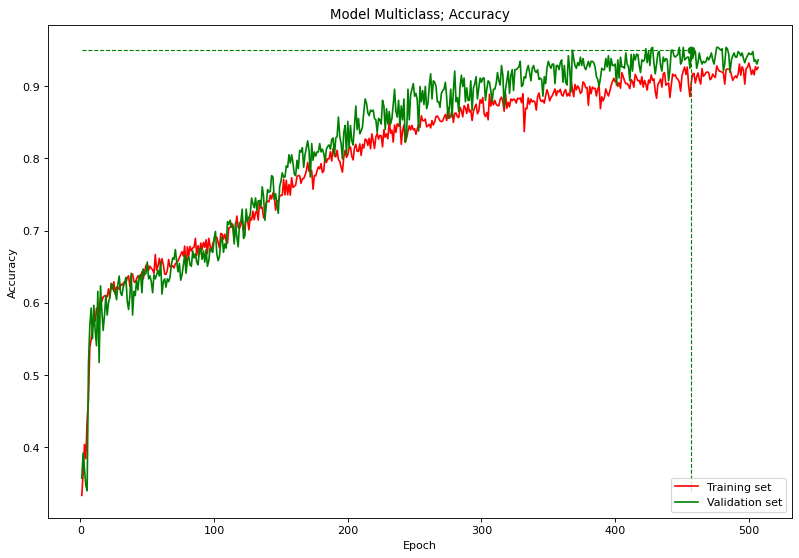

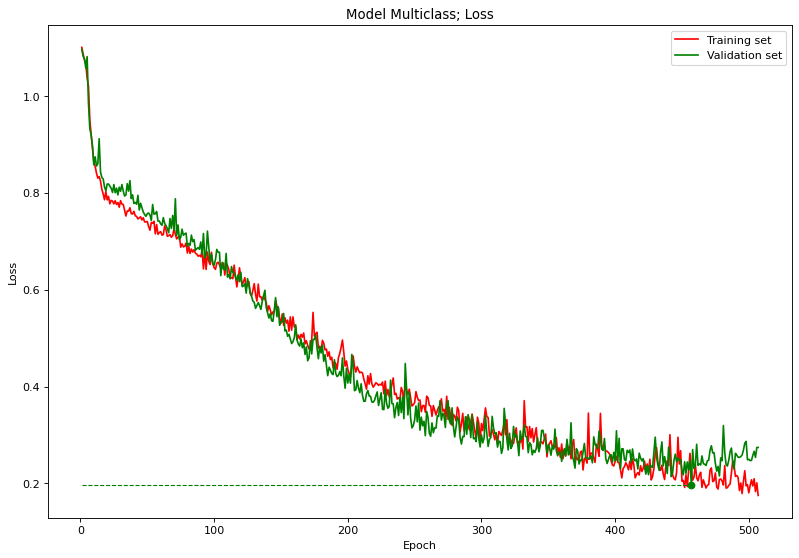

In [49]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Model2Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Model2Loss_figure.png')

# Visualize Results and predictions

In [39]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

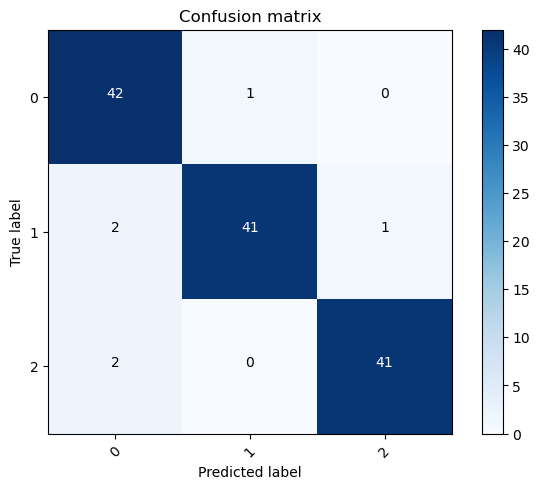

In [42]:
# val_pred_0 = np.argmax(opt_model_0.predict(test_data_0), axis=-1)
# # pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_0, pred_classes_0) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrix_0.png')

5/5 [==============================] - 0s 30ms/step


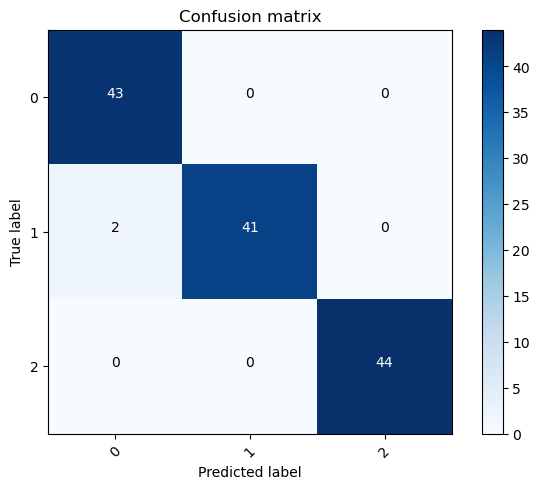

In [41]:
val_pred_1 = np.argmax(opt_model_1.predict(test_data_1), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_1, val_pred_1) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrix_1.png')

5/5 [==============================] - 0s 41ms/step


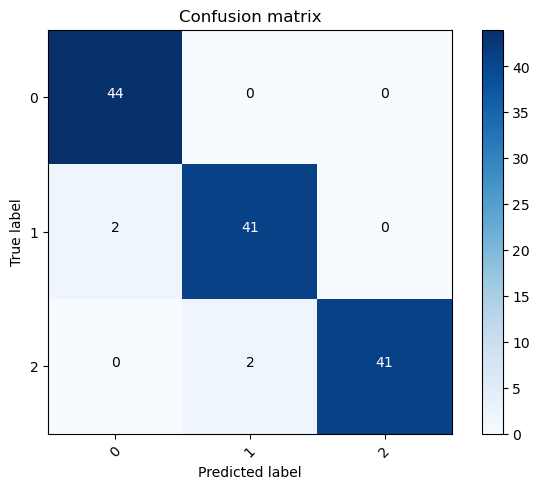

In [50]:
val_pred_2 = np.argmax(opt_model_2.predict(test_data_2), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_2, val_pred_2) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrix_2.png')

In [ ]:
# fig = plt.figure()
# plt.matshow(cm)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.ylabel('True Label')
# plt.xlabel('Predicated Label')
# plt.savefig('confusion_matrix'+str(learning_values.pop())+'.jpg')

## Attempt to perfom cross prediction using a never-seen dataset (import CBIS-DDSM).

In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None
cbis_path = '/kaggle/input/cbis-ddsmpatched/CBIS_DDSM'

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
testing_images, testing_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = testing_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
testing_labels = np.array([remap_label(l) for l in testing_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
testing_labels = to_categorical(testing_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
testing_images = testing_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_gene = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
val_gene = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')
